In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided

from sklearn import preprocessing

from qiskit import QuantumCircuit, execute
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit import transpile
from qiskit_aer import AerSimulator

In [13]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

# Pytorch
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn

# Pytorch lightning wrapper
import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [10]:
def pool2d(A, kernel_size, stride, padding=0, pool_mode='max'):
    '''
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window over which we take pool
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''
    # Padding
    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)

    shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])

    A_w = as_strided(A, shape_w, strides_w)

    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(2, 3))
    elif pool_mode == 'avg':
        return A_w.mean(axis=(2, 3))


def encoder(image):
    image = pool2d(image, 2, 2)
    qc = QuantumCircuit(14)

    for ii in range(14):
        qc.ry( image[ii, ii], ii)

    for ii in range(14):
        for jj in range(ii+1, 14):
            qc.cry( image[ii, ii], ii, jj)

    for ii in range(14):
        qc.h(ii)

    qc.measure_all()

    return qc

def run_qc(qc, num_shots):
    res = execute(qc, AerSimulator(method="statevector"), num_shots=num_shots)
    cnt = res.result().get_counts()
    sv = np.zeros(2**qc.num_qubits)
    for key, val in cnt.items():
        sv[int(key, base=2)] = val/num_shots

    return sv

In [2]:
data = np.load("data/images.npy")
labels = np.load("data/labels.npy")

max_num_qubits = 16
lin_data = [dd.reshape(-1) for dd in data]
norm_lin_data = preprocessing.normalize(lin_data)
norm_data = np.array( [nd.reshape(28, 28) for nd in norm_lin_data] )

In [12]:
encoded_images = np.array([
    run_qc(
        encoder(img),
        10000
    )
    for img in tqdm(norm_data)
 ])

100%|██████████| 2000/2000 [10:38<00:00,  3.13it/s]


In [37]:
encoded_images = encoded_images.astype(np.float32)
norm_data = norm_data.astype(np.float32)

In [38]:
class Qkdataset(Dataset):
    def __init__(self, data, label, transform=None, target_transform=None):
        self.img_labels = label
        self.imgs = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx].astype(float)
        label = self.img_labels[idx].astype(float)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [77]:
class AutoEncoder(pl.LightningModule):

    def __init__(self, num_qubits):
        super().__init__()
        # Decoder
        self.decoder =  nn.Sequential(
                                        # Second linear layer
                                        nn.Linear(2**num_qubits, 3*3*32), # (64, 288)
                                        nn.ReLU(True),
                                        # Unflatten
                                        nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
                                        # First transposed convolution
                                        nn.ConvTranspose2d(32, 16, kernel_size=3, output_padding=0, stride=2),
                                        nn.ReLU(True),
                                        # Second transposed convolution
                                        nn.ConvTranspose2d(16, 8, kernel_size=3, output_padding=1, padding=1, stride=2),
                                        nn.ReLU(True),
                                        ## Third transposed convolution
                                        nn.ConvTranspose2d(8, 1, kernel_size=3, output_padding=1, padding=1, stride=2),
                                        # To obtain an output in [0,1]
                                        nn.Sigmoid()
                                    )
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.decoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x, y = batch
        x_hat = self.decoder(x)
        loss = self.loss_fn(x_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx, loss_name='validation_loss'):
        x, y = batch
        x_hat = self.decoder(x)
        val_loss = self.loss_fn(x_hat, y)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0008157670205790078, weight_decay=1.4786239067036069e-05)
        return optimizer

    def configure_loss(self, loss_fn):
        self.loss_fn = loss_fn

In [78]:
train_dataset = Qkdataset(encoded_images, norm_data)
train_transform = transforms.Compose([
#    random_transform,
    transforms.ToTensor(),
])

train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                         [1900, 100])

### Define train dataloader
train_dataloader = DataLoader(train_set, batch_size=256, shuffle=True)
### Define validation dataloader
val_dataloader = DataLoader(val_set, batch_size=256, shuffle=False)

In [79]:
### Set the random seed for reproducible results
torch.manual_seed(49)
np.random.seed(49)

### Initialize the two networks
num_qubs = 14
auto_enc = AutoEncoder(num_qubits=num_qubs)
auto_enc.double()

AutoEncoder(
  (decoder): Sequential(
    (0): Linear(in_features=16384, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (10): Sigmoid()
  )
)

In [80]:
### Define the loss function
loss_fn = torch.nn.MSELoss()
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
auto_enc.to(device)
auto_enc.configure_loss(loss_fn)

Selected device: cpu


In [81]:
trainer = pl.Trainer(max_epochs=100, 
                     callbacks=[EarlyStopping(monitor='validation_loss')])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [82]:
trainer.fit(auto_enc, train_dataloader, val_dataloader)


  | Name    | Type       | Params
---------------------------------------
0 | decoder | Sequential | 1.1 M 
1 | loss_fn | MSELoss    | 0     
---------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.293     Total estimated model params size (MB)


/home/utente/py_env/py_tn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/utente/py_env/py_tn/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 28, 28])) that is different to the input size (torch.Size([100, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/utente/py_env/py_tn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottlene

Epoch 0:   0%|          | 0/9 [00:00<?, ?it/s] 

/home/utente/py_env/py_tn/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([256, 28, 28])) that is different to the input size (torch.Size([256, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0:  89%|████████▉ | 8/9 [00:03<00:00,  2.39it/s, loss=0.2, v_num=10]  

/home/utente/py_env/py_tn/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([108, 28, 28])) that is different to the input size (torch.Size([108, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 99: 100%|██████████| 9/9 [00:02<00:00,  3.29it/s, loss=0.000941, v_num=10, validation_loss=0.000934]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:02<00:00,  3.24it/s, loss=0.000941, v_num=10, validation_loss=0.000934]


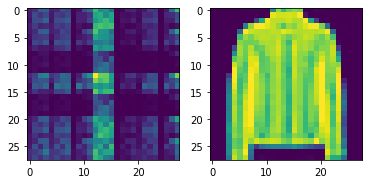

In [116]:
idx = -5

tt = torch.from_numpy(encoded_images[idx]).double().reshape(1, -1)
new_tt = auto_enc.forward( tt)


fig, ax = plt.subplots(1, 2)

ax[0].imshow(new_tt.detach().numpy().reshape(28, 28))
ax[1].imshow(norm_data[idx])

plt.show()

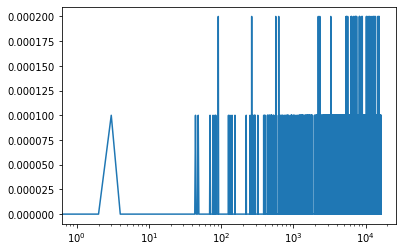

In [122]:
plt.plot(encoded_images[10])
plt.xscale("log")